In [1]:
import perceval as pcvl
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [2]:
# Calculate the probability of an outcome for detector
def calculate_proba(n,m,measure,allstateprobs_iterator):
    r"""
    gives the probability of an output measurement
    :param n: number of spatial states
    :param m: number of internal states
    :param measure: array of how much photon we expect for each captor (array 1,n)
    :param allstateprobs_iterator: An iterator containing states and probabilities of the simulation
    :return: float probability
    """
    Proba = 0
    k = 0
    theta = np.pi/4
    c = [np.cos(theta),np.sin(theta)]
    for state, probabilitie in allstateprobs_iterator:
        ls = list(state)
        #print(state,probabilitie)
        capt = []
        for i in range(n):
            capt.append(np.sum(ls[i::n]))
        #print(capt)
        if np.all(capt==measure):
            #print(state)
            #print(probabilitie)
            Proba += probabilitie
        k+=1
    return Proba

def create_inputs(enterFunc,Coefs,Dictionnary = None): 
    #enterFunc is the distribution in space of the entry in the system ex: [1,1]
    if any(np.array(enterFunc)>1):
        raise Exception('Cannot be more than 1 photon per spatial mode')
        
    internMode = np.sum(enterFunc)
    spatialMode = len(enterFunc)
    nbPhoton = np.sum(enterFunc)
    L = spatialMode*internMode 

    Inputs = []
    for x in itertools.combinations(range(L), nbPhoton) :
        inputsTemps = [1 if i in x else 0 for i in range(L)]
        Inputs.append(np.array(inputsTemps))
    
    realInputs = []

    for i in range(len(Inputs)):
        compare = np.zeros(spatialMode)
        for ii in range(0,L,spatialMode):
            compare += Inputs[i][ii:ii+spatialMode]

        if np.all(compare == enterFunc):
            realInputs.append(Inputs[i])
    #print(realInputs)
    c = []
    Arr = np.squeeze(Coefs)
    
    for i in range(len(realInputs)):
        ArrCond = np.array(realInputs[i]).reshape(internMode,spatialMode).T
        y = np.ma.masked_array(Arr, abs(ArrCond-1))
        c.append(np.prod(y))

    k = 0

    if isinstance(Dictionnary,dict) and len(Dictionnary)!=0:
        testdict = {}

        iterkeys = itertools.permutations(Dictionnary.keys(),2)
        iterval = itertools.permutations(Dictionnary.values(),2)
        for i,j in zip(iterkeys,iterval) :
            dictkey = '|' + i[0] + ',' + i[1] + '>'
            dictval = j[0] + j[1]
            testdict[dictkey] = pcvl.BasicState(dictval)
        for i in realInputs:
            nameOfState = str(pcvl.BasicState(i))
            if k == 0:
                InputsBS = testdict[nameOfState]
                
            else:
                InputsBS = InputsBS + testdict[nameOfState]

            k += 1
        #Add the coefficient in the state vector
        k = 0
        for state,amplitude in InputsBS.items():

            InputsBS[state] = amplitude*c[k]
            k+=1
        
        return InputsBS,testdict
    else:     
        for i in realInputs:
            if k == 0 :
                InputsBS = pcvl.BasicState(i)
            else :
                InputsBS = InputsBS + pcvl.BasicState(i)
            k += 1
        #Add the coefficient in the state vector
        k = 0
        for state,amplitude in InputsBS.items():

            InputsBS[state] = amplitude*c[k]
            k+=1
        
        return InputsBS

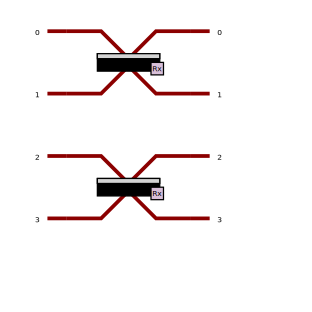

In [7]:
## Create the circuit

n = 2 #Nombre de modes spatiaux
m = 2 #Nombre de modes internes
nbPhoton = 2 #Nombre de photon
circuit = pcvl.Circuit(n*m)
circuit.add((0,1), pcvl.BS())
circuit.add((2,3),pcvl.BS())

pcvl.pdisplay(circuit)

In [8]:
theta = np.pi/3
statesdict = {
    "0,0": [1, 0, 1, 0],
    "0,1": [1, 0, 0, 1],
    "1,0": [0, 1, 1, 0],
    "1,1": [0, 1, 0, 1]
}
C = np.array([[1,0,0,0],[np.cos(theta),np.sin(theta),0,0],[1/np.sqrt(3),1/np.sqrt(3),1/np.sqrt(3),0],[1/np.sqrt(4),1/np.sqrt(4),1/np.sqrt(4),1/np.sqrt(4)]])
InputsBS = create_inputs([1,0,1,0],C,statesdict)


#Get backend and simulation
backend = pcvl.BackendFactory.get_backend("Naive")

simulator = backend(circuit)
Sol = simulator.allstateprob_iterator(InputsBS)

#Prob = calculate_proba(n,m,[1,1],Sol)

[array([1, 0, 1, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 1, 0]), array([0, 0, 1, 0, 1, 0, 0, 0]), array([0, 0, 0, 0, 1, 0, 1, 0])]


MaskError: Mask and data not compatible: data size is 16, mask size is 8.

Test CNOT

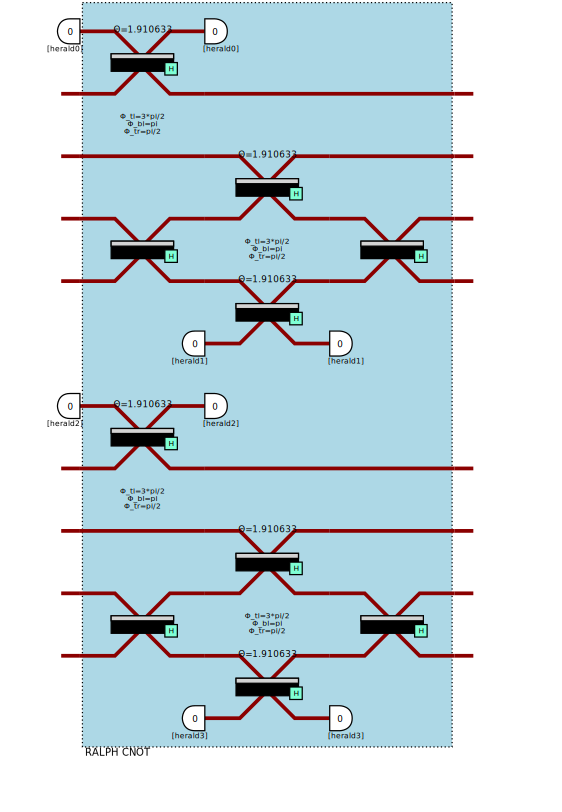

In [3]:
n = 3 #Nombre de modes spatiaux
m = 3 #Nombre de modes internes
k = 3 #Nombre de photon
cnot = pcvl.Circuit(12, name="Ralph CNOT")
cnot.add((0, 1), pcvl.BS.H(pcvl.BS.r_to_theta(1/3), phi_tl = -np.pi/2, phi_bl = np.pi, phi_tr = np.pi / 2))
cnot.add((3, 4), pcvl.BS.H())
cnot.add((2, 3), pcvl.BS.H(pcvl.BS.r_to_theta(1/3), phi_tl = -np.pi/2, phi_bl = np.pi, phi_tr = np.pi / 2))
cnot.add((4, 5), pcvl.BS.H(pcvl.BS.r_to_theta(1/3)))
cnot.add((3, 4), pcvl.BS.H())
#first copy
cnot.add((6, 7), pcvl.BS.H(pcvl.BS.r_to_theta(1/3), phi_tl = -np.pi/2, phi_bl = np.pi, phi_tr = np.pi / 2))
cnot.add((9, 10), pcvl.BS.H())
cnot.add((8, 9), pcvl.BS.H(pcvl.BS.r_to_theta(1/3), phi_tl = -np.pi/2, phi_bl = np.pi, phi_tr = np.pi / 2))
cnot.add((10, 11), pcvl.BS.H(pcvl.BS.r_to_theta(1/3)))
cnot.add((9, 10), pcvl.BS.H())
""" #second copy
cnot.add((12, 13), pcvl.BS.H(pcvl.BS.r_to_theta(1/3), phi_tl = -np.pi/2, phi_bl = np.pi, phi_tr = np.pi / 2))
cnot.add((15, 16), pcvl.BS.H())
cnot.add((14, 15), pcvl.BS.H(pcvl.BS.r_to_theta(1/3), phi_tl = -np.pi/2, phi_bl = np.pi, phi_tr = np.pi / 2))
cnot.add((16, 17), pcvl.BS.H(pcvl.BS.r_to_theta(1/3)))
cnot.add((15, 16), pcvl.BS.H())
#third copy
cnot.add((18, 19), pcvl.BS.H(pcvl.BS.r_to_theta(1/3), phi_tl = -np.pi/2, phi_bl = np.pi, phi_tr = np.pi / 2))
cnot.add((21, 22), pcvl.BS.H())
cnot.add((20, 21), pcvl.BS.H(pcvl.BS.r_to_theta(1/3), phi_tl = -np.pi/2, phi_bl = np.pi, phi_tr = np.pi / 2))
cnot.add((22, 23), pcvl.BS.H(pcvl.BS.r_to_theta(1/3)))
cnot.add((21, 22), pcvl.BS.H())
pcvl.pdisplay(cnot) """

p = pcvl.Processor("Naive", cnot)
p.set_postprocess(lambda s: (s[1] or s[2] or s[7] or s[8]) and (s[3] or s[4] or s[9] or s[10]))
p.add_herald(0, 0)
p.add_herald(5, 0)
p.add_herald(6, 0)
p.add_herald(11, 0)
""" p.add_herald(12, 0)
p.add_herald(17, 0)
p.add_herald(18, 0)
p.add_herald(23, 0) """
#  and (s[13] or s[14]) and (s[15] or s[16]) and (s[19] or s[20]) and (s[21] or s[22])
# and (s[7] or s[8]) and (s[9] or s[10])

pcvl.pdisplay(p, recursive = True)




In [ ]:
theta1 = np.pi/16
theta2 = np.pi/3
statesdict = {
    "0,0": [1, 0, 1, 0],
    "0,1": [1, 0, 0, 1],
    "1,0": [0, 1, 1, 0],
    "1,1": [0, 1, 0, 1]
}
C = np.array([[np.cos(theta1),np.sin(theta1)],[np.cos(theta2),np.sin(theta2)]])
#C = np.array([[1,0],[1,0]])
InputsBS,testDict = create_inputs([1,1],C,statesdict)

testDictSwap = {v: k for k, v in testDict.items()}
realOutput = {}
print(InputsBS)
for i in range(len(InputsBS)):
    miniState = InputsBS[i]
    p.with_input(miniState)
    output = p.probs()['results']
    for ii in output.keys():
        realOutput[ii] = output[ii] * InputsBS[miniState]



""" for i,j in zip(realOutput.keys(),realOutput.values()):
    

    print(testDictSwap[i],j) """



In [4]:
theta = np.pi/32
C = np.array([[0,0],[1,0],[0,0],[np.cos(theta),np.sin(theta)]])
InputsBS = create_inputs([0,1,0,1],C)

print(InputsBS)


pcvl.pdisplay(p, recursive = True)
realOutput = {}
for i in range(len(InputsBS)):
    miniState = InputsBS[i]
    #print(miniState,':',InputsBS[miniState])
    p.with_input(miniState)
    output = p.probs()['results']
    for ii in output.keys():
        if ii in realOutput.keys():
            realOutput[ii] = realOutput[ii] + output[ii] * abs(InputsBS[InputsBS[i]]) ** 2
        else:
            realOutput[ii] = output[ii] * abs(InputsBS[InputsBS[i]]) ** 2
K = 0

for i,j in zip(realOutput.keys(),realOutput.values()):
    print(i,j)
    K += j

print(K)



0.995185*|0,1,0,1,0,0,0,0>+0.098017*|0,1,0,0,0,0,0,1>
|0,1,1,0,0,0,0,0> 0.9903926402016153
|0,1,0,0,0,0,0,1> 0.003202453266128258
|0,0,1,0,0,1,0,0> 0.003202453266128259
|0,0,0,1,0,1,0,0> 0.003202453266128258
1.0


In [8]:
print(p)

In [5]:
# Graph
thetaArr = np.linspace(0,np.pi/2,100)
p = pcvl.Processor("Naive", cnot)
p.set_postprocess(lambda s: (s[1] or s[2] or s[7] or s[8]) and (s[3] or s[4] or s[9] or s[10]))
p.add_herald(0, 0)
p.add_herald(5, 0)
p.add_herald(6, 0)
p.add_herald(11, 0)
""" p.add_herald(12, 0)
p.add_herald(17, 0)
p.add_herald(18, 0)
p.add_herald(23, 0) """
#  and (s[13] or s[14]) and (s[15] or s[16]) and (s[19] or s[20]) and (s[21] or s[22])
# and (s[7] or s[8]) and (s[9] or s[10])
plotArr = []
for theta in thetaArr:

    C = np.array([[0,0],[1,0],[0,0],[np.cos(theta),np.sin(theta)]])
    InputsBS = create_inputs([0,1,0,1],C)


    realOutput = {}
    for i in range(len(InputsBS)):
        miniState = InputsBS[i]
        #print(miniState,':',InputsBS[miniState])
        p.with_input(miniState)
        output = p.probs()['results']
        for ii in output.keys():
            if ii in realOutput.keys():
                realOutput[ii] = realOutput[ii] + output[ii] * InputsBS[InputsBS[i]] ** 2
            else:
                realOutput[ii] = output[ii] * InputsBS[InputsBS[i]] ** 2
    ind = list(realOutput.keys())
    
    plotArr.append(realOutput[ind[0]])
#print(plotArr)

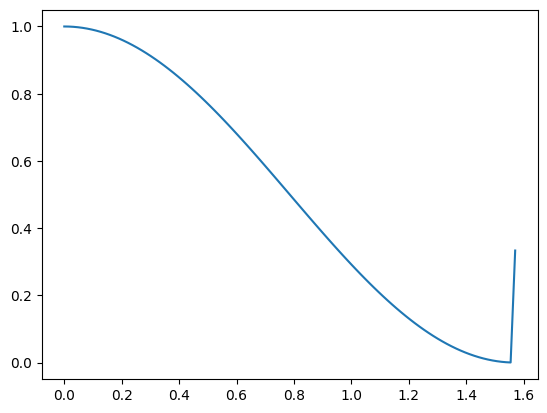

In [6]:
import matplotlib.pyplot as plt
plt.plot(thetaArr,plotArr)